In [67]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn import metrics
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Meta Data

In this project, we are predicting the probability that an online transaction is fraudulent, 
as denoted by the binary target isFraud. The data is broken into two files identity and transaction, 
which are joined by TransactionID. Not all transactions have corresponding identity information.

**Transaction Table**

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Identity Table**

- **DeviceType**
- **DeviceInfo**
- **id_01 - id_38**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement

### Feature Engineering

In this notebook, we will be primarily focused on feature engineering.

Baseline Model:

- Model: XG-Boost

Feature Engineering (important)
- Time
- Day of week (one hot)
- Hour of day (one hot)
- Transaction Amount (take log when linear model?)
- Product Code (one hot)
- Card information
- 4 & 6 (one hot)
- Others : consider later (large amount of categorical data)
- Address
- Top 10 countries and other
- Region: consider later
- Dist
    - Dist1, Dist2 (direct)
- Email_Domain
    - P & R: Top 20 and other
- Count
    - 1-14
- D
    - Consider later
- M1 - M9
    - One hot
- V:
    - Standardized and PCA

龙：
- Device Type & Info:
- One hot
- ID
- IP: feature engineering
    - (If already featured: direct as numeric)
    - (tags < 10): one - hot
    - (tags > 10): consider later


### Load Data

In [2]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
test_transaction_path = "data/test_transaction.csv"
test_identity_path = "data/test_identity.csv"
# sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
# test_transaction = pd.read_csv(test_transaction_path)
# test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='left')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]
train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 144233 rows & 434 columns.


In [3]:
train_transaction.shape

(590540, 394)

In [4]:
train_identity.shape

(144233, 41)

In [5]:
# test_transaction.shape

In [6]:
# test_identity.shape

In [7]:
# release data from those four
del train_transaction
del train_identity
# del test_transaction
# del test_identity

### Feature Engineering

In [8]:
train_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
## Day of week (one hot)
def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

# Hour of day (one hot)
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def addr1_transform(x):
    if x in top_ten_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_ten_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_twenty_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_twenty_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [10]:
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)
# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))
# Product Code (one hot)
train_df['ProductCD'].value_counts()
# Card information
train_df['card4'].value_counts()
train_df['card6'].value_counts()
#addr1, addr2
top_ten_addr1 = list(train_df['addr1'].value_counts().index)[:10] #top ten regions
top_ten_addr2 = list(train_df['addr2'].value_counts().index)[:10] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

#Email_Domain
top_twenty_email_p = list(train_df['P_emaildomain'].value_counts().index)[:20] #top ten regions
top_twenty_email_r = list(train_df['R_emaildomain'].value_counts().index)[:20] #top ten countries
train_df['P_emaildomain'].value_counts()
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)
# Count 1-14
train_df['C1'].value_counts()
#M1 - M9
train_df['M1'].value_counts()
# V: Standardized and PCA
train_df['V3'].value_counts()

Series([], Name: V3, dtype: int64)

In [11]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new', 
              'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log']

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder()
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())
v_data = train_df.iloc[:, 95:434].fillna(0).to_numpy()
nums_part = train_df[num_list]
v = pd.DataFrame(v_data)
nums = pd.concat([nums_part, v], axis = 1)

### Construct Balanced Data Set

In [12]:
X = pd.concat([nums, cates], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]

# inbalanced data (Raw Ratio)
X_inb = X.copy()
y_inb = y.copy()

# balanced data
combined_data = pd.concat([X, y], axis=1)
combined_data_0 = combined_data[combined_data['isFraud'] == 0]
combined_data_1 = combined_data[combined_data['isFraud'] == 1]
# combined_data_0_10000 = combined_data_0.sample(n=10000, replace=False, ignore_index=True)
# combined_data_1_10000 = combined_data_1.sample(n=10000, replace=False, ignore_index=True)
combined_data_0_10000 = combined_data_0.sample(n=10000, replace=False).reset_index(drop=True)
combined_data_1_10000 = combined_data_1.sample(n=10000, replace=False).reset_index(drop=True)
combined_data_10000 = pd.concat([combined_data_0_10000, combined_data_1_10000])
X_b = combined_data_10000.drop(columns=['isFraud'])
y_b = combined_data_10000['isFraud']

# 2:1 ratio
combined_data_0_20000 = combined_data_0.sample(n=20000, replace=True).reset_index(drop=True)
combined_data_1_10000 = combined_data_1.sample(n=10000, replace=False).reset_index(drop=True)
combined_data_20000 = pd.concat([combined_data_0_20000, combined_data_1_10000])
X_2 = combined_data_20000.drop(columns=['isFraud'])
y_2 = combined_data_20000['isFraud']

### Train Test Split

In [13]:
#Raw Ratio
X_train_inb, X_test_inb, y_train_inb, y_test_inb = train_test_split(X_inb, y_inb, stratify=y_inb, random_state=590540)

# Balanced Data
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, stratify=y_b, random_state=590540)

# 2:1 Ratio
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, stratify=y_2, random_state=590540)

### XGBoost Decision Tree - Raw Ratio

In [14]:
#Raw Ratio
def XGBoost_DT(X_train, X_test, y_train, y_test):
    xgb_cl = xgb.XGBClassifier()
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = xgb_cl.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [15]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train_inb, X_test_inb, y_train_inb, y_test_inb)

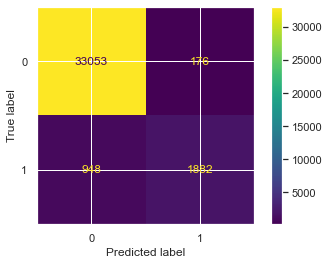

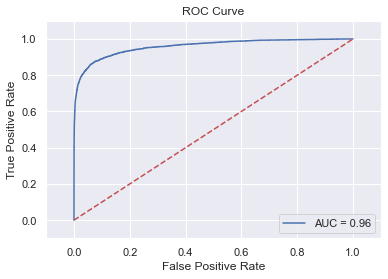

In [16]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### XGBoost Decision Tree - Balanced Ratio

In [17]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train_2, X_test_2, y_train_2, y_test_2)

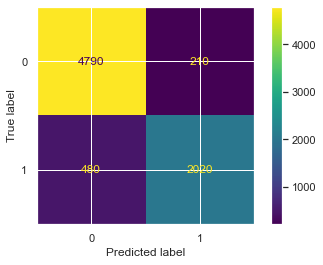

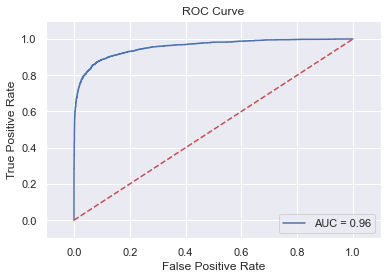

In [18]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### XGBoost Decision Tree - 2:1 Ratio

In [19]:
xgb_cl, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = XGBoost_DT(X_train_b, X_test_b, y_train_b, y_test_b)

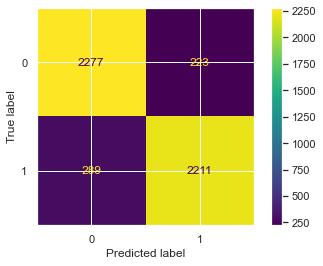

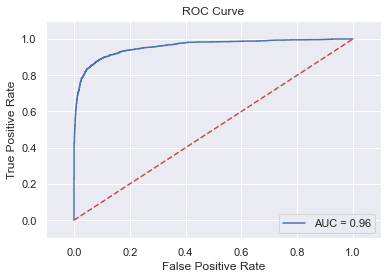

In [20]:
plot_confusion_matrix(xgb_cl, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression - Raw Ratio

In [21]:
X_train_inb_0 = X_train_inb.fillna(0)
X_test_inb_0 = X_test_inb.fillna(0)

In [22]:
#Raw Ratio
def logistic_regression(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = clf.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [23]:
lr_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = logistic_regression(X_train_inb_0, X_test_inb_0, y_train_inb, y_test_inb)

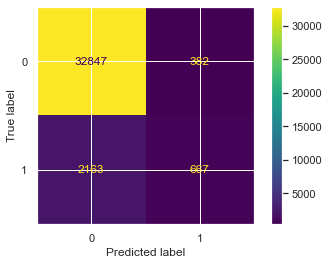

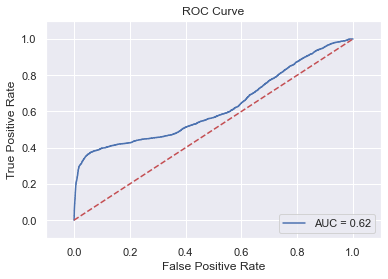

In [24]:
plot_confusion_matrix(lr_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression - Balanced Ratio 

In [25]:
X_train_b_0 = X_train_b.fillna(0)
X_test_b_0 = X_test_b.fillna(0)

In [26]:
lr_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = logistic_regression(X_train_b_0, X_test_b_0, y_train_b, y_test_b)

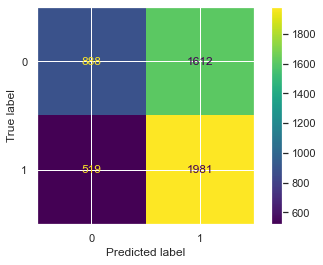

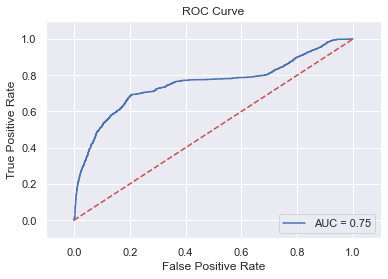

In [27]:
plot_confusion_matrix(lr_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression - 2：1 Ratio

In [28]:
X_train_2_0 = X_train_2.fillna(0)
X_test_2_0 = X_test_2.fillna(0)

In [29]:
lr_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = logistic_regression(X_train_2_0, X_test_2_0, y_train_2, y_test_2)

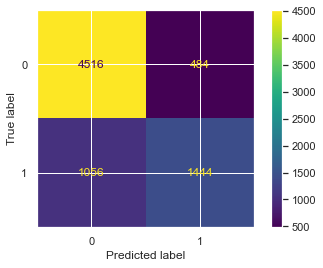

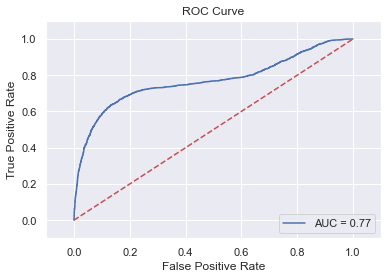

In [30]:
plot_confusion_matrix(lr_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Decision Trees - Raw Ratio

In [34]:
def DT(X_train, X_test, y_train, y_test):
    clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = clf.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [35]:
dt_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = DT(X_train_inb_0, X_test_inb_0, y_train_inb, y_test_inb)

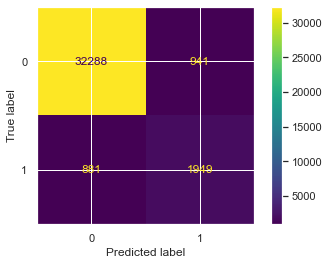

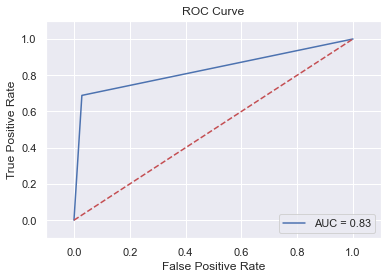

In [36]:
plot_confusion_matrix(dt_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Decision Trees - Balanced Ratio

In [37]:
dt_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = DT(X_train_b_0, X_test_b_0, y_train_b, y_test_b)

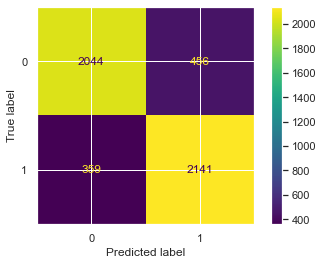

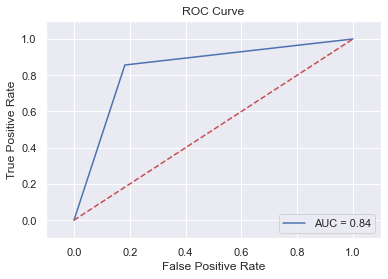

In [38]:
plot_confusion_matrix(dt_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Decision Trees - 2：1 Ratio

In [39]:
dt_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = DT(X_train_2_0, X_test_2_0, y_train_2, y_test_2)

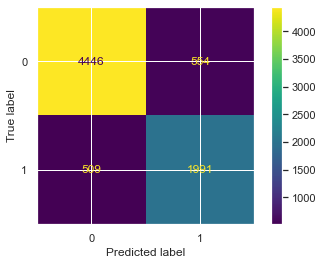

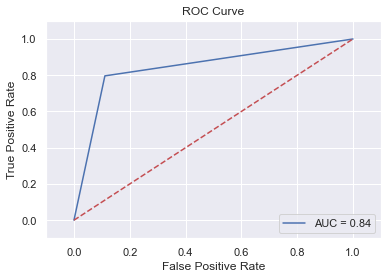

In [40]:
plot_confusion_matrix(dt_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes - Raw Ratio

In [54]:
def nb_model(X_train, X_test, y_train, y_test):
    clf = GaussianNB().fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = clf.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [56]:
nb_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = nb_model(X_train_inb_0, X_test_inb_0, y_train_inb, y_test_inb)

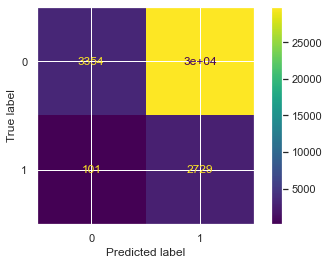

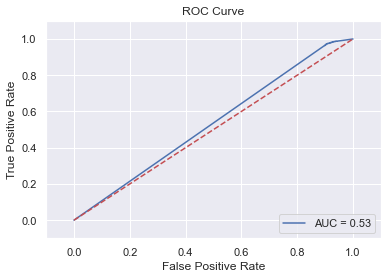

In [57]:
plot_confusion_matrix(nb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes - Balanced Ratio

In [59]:
nb_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = nb_model(X_train_b_0, X_test_b_0, y_train_b, y_test_b)

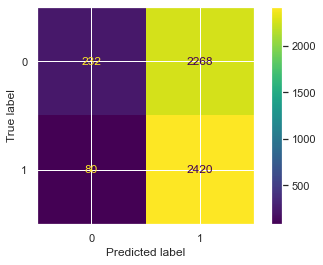

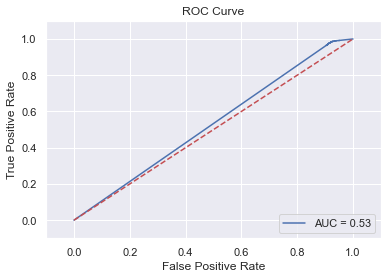

In [60]:
plot_confusion_matrix(nb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Naive Bayes - 2：1 Ratio

In [61]:
nb_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = nb_model(X_train_2_0, X_test_2_0, y_train_2, y_test_2)

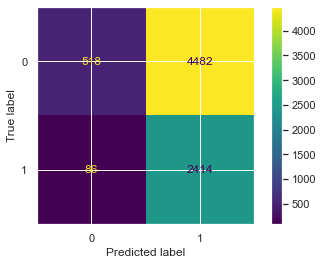

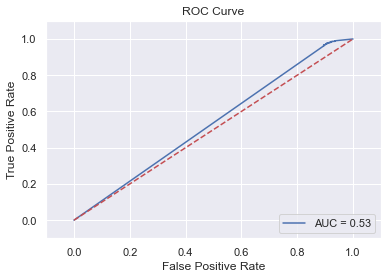

In [62]:
plot_confusion_matrix(nb_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### k-Nearest Neighbors - Raw Ratio

In [71]:
def knn(X_train, X_test, y_train, y_test):
    clf = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = clf.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [72]:
knn_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = knn(X_train_inb_0, X_test_inb_0, y_train_inb, y_test_inb)

KeyboardInterrupt: 

In [ ]:
plot_confusion_matrix(knn_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### k-Nearest Neighbors - Balanced Ratio

In [ ]:
knn_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = knn(X_train_b_0, X_test_b_0, y_train_b, y_test_b)

In [ ]:
plot_confusion_matrix(knn_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### k-Nearest Neighbors - 2：1 Ratio

In [31]:
knn_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = knn(X_train_2_0, X_test_2_0, y_train_2, y_test_2)

In [ ]:
plot_confusion_matrix(knn_clf, X_test, y_test)
plt.show()
plt.clf()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Support Vector Machine - Raw Ratio

In [63]:
def svc_model(X_train, X_test, y_train, y_test):
    clf = SVC().fit(X_train, y_train)
    preds = clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    y_preds = clf.predict_proba(X_test)
    preds = y_preds[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    return clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score

In [42]:
# svc_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = svc_model(X_train_inb_0, X_test_inb_0, y_train_inb, y_test_inb)

In [43]:
# plot_confusion_matrix(svc_clf, X_test, y_test)
# plt.show()
# plt.clf()
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc='lower right')
# plt.show()

### Support Vector Machine - Balanced Ratio

In [44]:
# svc_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = svc_model(X_train_b_0, X_test_b_0, y_train_b, y_test_b)

In [45]:
# plot_confusion_matrix(svc_clf, X_test, y_test)
# plt.show()
# plt.clf()
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc='lower right')
# plt.show()

### Support Vector Machine - 2：1 Ratio

In [65]:
# svc_clf, accuracy, X_test, y_test, y_preds, preds, fpr, tpr, auc_score = svc_model(X_train_2_0, X_test_2_0, y_train_2, y_test_2)

In [66]:
# plot_confusion_matrix(svc_clf, X_test, y_test)
# plt.show()
# plt.clf()
# plt.title('ROC Curve')
# plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.1])
# plt.ylim([-0.1,1.1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc='lower right')
# plt.show()